<a href="https://colab.research.google.com/github/pvpogorelova/metrics_24_25/blob/main/Sem_30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Семинар 30. ETS модели (на примере данных о свадьбах в РФ)**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

In [2]:
# Загрузим набор данных по свадьбам
m = pd.read_csv('marriages.csv')
m

,code,name,total,date
0,30,Центральный федеральный округ,14845.0,2006-01-01
1,30,Центральный федеральный округ,16414.0,2006-02-01
2,30,Центральный федеральный округ,15753.0,2006-03-01
3,30,Центральный федеральный округ,21803.0,2006-04-01
4,30,Центральный федеральный округ,9384.0,2006-05-01
...,...,...,...,...
20596,99000000000,Еврейская автономная область,40.0,2021-05-01
20597,99000000000,Еврейская автономная область,106.0,2021-06-01
20598,99000000000,Еврейская автономная область,96.0,2021-07-01
20599,99000000000,Еврейская автономная область,108.0,2021-08-01


In [3]:
# Преобразование даты в формат "год-месяц"
m['date'] = pd.to_datetime(m['date']).dt.to_period('M')
print(m)

              code                           name    total     date
0               30  Центральный федеральный округ  14845.0  2006-01
1               30  Центральный федеральный округ  16414.0  2006-02
2               30  Центральный федеральный округ  15753.0  2006-03
3               30  Центральный федеральный округ  21803.0  2006-04
4               30  Центральный федеральный округ   9384.0  2006-05
...            ...                            ...      ...      ...
20596  99000000000   Еврейская автономная область     40.0  2021-05
20597  99000000000   Еврейская автономная область    106.0  2021-06
20598  99000000000   Еврейская автономная область     96.0  2021-07
20599  99000000000   Еврейская автономная область    108.0  2021-08
20600  99000000000   Еврейская автономная область     78.0  2021-09

[20601 rows x 4 columns]


In [4]:
# Создание временного ряда для России (код 643)
marr_rf = m[m['code'] == 643].set_index('date').sort_index()
print(marr_rf)
marr_rf = marr_rf.iloc[:-2, :]
print(marr_rf)

         code                  name     total
date                                         
2006-01   643  Российская Федерация   55509.0
2006-02   643  Российская Федерация   62449.0
2006-03   643  Российская Федерация   70798.0
2006-04   643  Российская Федерация   86055.0
2006-05   643  Российская Федерация   35960.0
...       ...                   ...       ...
2021-05   643  Российская Федерация   46596.0
2021-06   643  Российская Федерация  100908.0
2021-07   643  Российская Федерация  125068.0
2021-08   643  Российская Федерация  120961.0
2021-09   643  Российская Федерация  102528.0

[189 rows x 3 columns]
         code                  name     total
date                                         
2006-01   643  Российская Федерация   55509.0
2006-02   643  Российская Федерация   62449.0
2006-03   643  Российская Федерация   70798.0
2006-04   643  Российская Федерация   86055.0
2006-05   643  Российская Федерация   35960.0
...       ...                   ...       ...
2021-03   

In [5]:
# Визуализация декомпозиции ряда
def plot_ts_decomposition(df, column='total'):
    fig = make_subplots(rows=4, cols=1, shared_xaxes=True)

    # Исходный ряд
    fig.add_trace(go.Scatter(x=df.index.to_timestamp(), y=df[column],
                             name='Исходный ряд'), row=1, col=1)

    # Сезонная декомпозиция
    result = seasonal_decompose(df[column], model='additive', period=12)

    # Тренд
    fig.add_trace(go.Scatter(x=df.index.to_timestamp(), y=result.trend,
                             name='Тренд'), row=2, col=1)

    # Сезонность
    fig.add_trace(go.Scatter(x=df.index.to_timestamp(), y=result.seasonal,
                             name='Сезонность'), row=3, col=1)

    # Остатки
    fig.add_trace(go.Scatter(x=df.index.to_timestamp(), y=result.resid,
                             name='Остатки'), row=4, col=1)

    fig.update_layout(height=800, title_text="Декомпозиция")
    fig.show()

plot_ts_decomposition(marr_rf)

In [19]:
# Разделение на обучающую и тестовую выборки
train = marr_rf[marr_rf.index < pd.Period('2019-08', freq='M')]
test = marr_rf[marr_rf.index >= pd.Period('2019-08', freq='M')]

In [20]:
test

,code,name,total
date,,,
2019-08,643,Российская Федерация,133217.0
2019-09,643,Российская Федерация,107033.0
2019-10,643,Российская Федерация,82727.0
2019-11,643,Российская Федерация,75722.0
2019-12,643,Российская Федерация,73199.0
2020-01,643,Российская Федерация,41233.0
2020-02,643,Российская Федерация,65799.0
2020-03,643,Российская Федерация,49667.0
2020-04,643,Российская Федерация,33787.0


In [21]:
# Моделирование
# 1. Сезонная наивная модель (SNAIVE)
last_season = train['total'].iloc[-12:].values
snaive_forecast = pd.Series(
    np.tile(last_season, 2),  # Повторяем последний сезон 2 раза
    index=test.index[:24]      # Индексы для 24 месяцев
)

In [22]:
# 2. ETS(A,A,A) - Holt-Winters с аддитивными компонентами
ets_aaa = ExponentialSmoothing(train['total'],
                              trend='add',
                              seasonal='add',
                              seasonal_periods=12, initialization_method="estimated").fit(method='basinhopping')
ets_aaa_forecast = ets_aaa.forecast(24)  # 2 года = 24 месяца

In [23]:
# 3. ETS(A,N,A) - Holt-Winters без тренда
ets_ana = ExponentialSmoothing(train['total'],
                              trend=None,
                              seasonal='add',
                              seasonal_periods=12).fit(method='basinhopping')
ets_ana_forecast = ets_ana.forecast(24)

In [26]:
# Визуализация результатов
marr_rf_vis = marr_rf[marr_rf.index >= pd.Period('2015-01', freq='M')]

fig = go.Figure()

# Фактические данные
fig.add_trace(go.Scatter(x=marr_rf_vis.index.to_timestamp(),
                         y=marr_rf_vis['total'],
                         name='Фактические данные',
                         line=dict(color='black')))

# Прогноз SNAIVE
fig.add_trace(go.Scatter(x=test.index[:24].to_timestamp(),
                         y=snaive_forecast,
                         name='SNAIVE прогноз',
                         line=dict(color='blue', dash='dot')))

# Прогноз ETS(A,A,A)
fig.add_trace(go.Scatter(x=test.index.to_timestamp(),
                         y=ets_aaa_forecast,
                         name='ETS(A,A,A) прогноз',
                         line=dict(color='red')))

# Прогноз ETS(A,N,A)
fig.add_trace(go.Scatter(x=test.index.to_timestamp(),
                         y=ets_ana_forecast,
                         name='ETS(A,N,A) прогноз',
                         line=dict(color='green')))

fig.update_layout(title='Прогноз числа браков в России',
                 xaxis_title='Дата',
                 yaxis_title='Количество браков',
                 hovermode='x unified')
fig.show()

In [27]:
# Отчет по модели ETS(A,A,A)
print("Отчет по модели ETS(A,A,A):")
print(ets_aaa.summary())

Отчет по модели ETS(A,A,A):
                       ExponentialSmoothing Model Results                       
Dep. Variable:                    total   No. Observations:                  163
Model:             ExponentialSmoothing   SSE                    21589049590.213
Optimized:                         True   AIC                           3080.377
Trend:                         Additive   BIC                           3129.877
Seasonal:                      Additive   AICC                          3085.127
Seasonal Periods:                    12   Date:                 Mon, 09 Jun 2025
Box-Cox:                          False   Time:                         09:42:25
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0637014                alpha                 Tr

In [28]:
ets_aaa_forecast

,0
2019-08,136246.274716
2019-09,114095.322381
2019-10,74286.542438
2019-11,59945.586095
2019-12,57707.200315
2020-01,29891.381982
2020-02,39234.100442
2020-03,41494.724148
2020-04,59614.656788
2020-05,17623.750694


In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred, model_name):

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    # MAPE с обработкой нулевых значений
    mask = y_true != 0  # Игнорируем нули в знаменателе
    mape = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

    return {
        'Model': model_name,
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'MAPE (%)': round(mape, 2)
    }

# Создаём список всех моделей и их прогнозов
models = [
    ('SNAIVE', snaive_forecast),
    ('ETS(A,A,A)', ets_aaa_forecast),
    ('ETS(A,N,A)', ets_ana_forecast)
]

# Вычисляем метрики для каждой модели
results = []
for name, forecast in models:
    # Обрезаем прогноз до длины тестовых данных (если нужно)
    y_true = test['total'][:len(forecast)]
    y_pred = forecast[:len(y_true)]
    results.append(calculate_metrics(y_true, y_pred, name))

# Преобразуем в DataFrame для красивого отображения
results_df = pd.DataFrame(results).set_index('Model')
display(results_df)

,MAE,RMSE,MAPE (%)
Model,,,
SNAIVE,16444.92,20505.78,29.14
"ETS(A,A,A)",14481.76,16986.09,23.98
"ETS(A,N,A)",12606.36,15845.75,22.47


In [30]:
# Кросс-валидация растущим окном
def time_series_cv(data, n_splits=5, horizon=24, model_type='snaive'):
    n_samples = len(data)
    fold_size = (n_samples - horizon) // n_splits

    metrics = []

    for i in range(1, n_splits + 1):
        # Разделение данных
        train_size = horizon + (i - 1) * fold_size
        train = data[:train_size]
        test = data[train_size:train_size + horizon]

        # Обучение модели
        if model_type == 'snaive':
            last_season = train.iloc[-12:].values
            forecast = np.tile(last_season, 2)[:horizon]
        elif model_type == 'ets_aaa':
            model = ExponentialSmoothing(train,
                                      trend='add',
                                      seasonal='add',
                                      seasonal_periods=12).fit(method='basinhopping')
            forecast = model.forecast(horizon)
        elif model_type == 'ets_ana':
            model = ExponentialSmoothing(train,
                                      trend=None,
                                      seasonal='add',
                                      seasonal_periods=12).fit(method='basinhopping')
            forecast = model.forecast(horizon)

        # Вычисление метрик
        mae = mean_absolute_error(test, forecast)
        rmse = np.sqrt(mean_squared_error(test, forecast))
        mape = np.mean(np.abs((test - forecast) / test)) * 100

        metrics.append({
            'Fold': i,
            'Train Size': len(train),
            'Test Size': len(test),
            'MAE': mae,
            'RMSE': rmse,
            'MAPE': mape
        })

    return pd.DataFrame(metrics)

# Применяем кросс-валидацию для каждой модели
cv_results = {}
models = {
    'SNAIVE': 'snaive',
    'ETS(A,A,A)': 'ets_aaa',
    'ETS(A,N,A)': 'ets_ana'
}

for model_name, model_type in models.items():
    print(f"Выполняется кросс-валидация растущим окном для {model_name}...")
    cv_results[model_name] = time_series_cv(
        data=marr_rf['total'],  # Ваш временной ряд
        n_splits=5,
        horizon=24,
        model_type=model_type
    )

# Сводные результаты по всем моделям
summary = []
for model_name, results in cv_results.items():
    mean_mae = results['MAE'].mean()
    mean_rmse = results['RMSE'].mean()
    mean_mape = results['MAPE'].mean()

    summary.append({
        'Model': model_name,
        'Avg MAE': mean_mae,
        'Avg RMSE': mean_rmse,
        'Avg MAPE': mean_mape
    })

summary_df = pd.DataFrame(summary).set_index('Model')
display(summary_df)

Выполняется кросс-валидация растущим окном для SNAIVE...
Выполняется кросс-валидация растущим окном для ETS(A,A,A)...
Выполняется кросс-валидация растущим окном для ETS(A,N,A)...


,Avg MAE,Avg RMSE,Avg MAPE
Model,,,
SNAIVE,13204.391667,17259.561515,18.041220
"ETS(A,A,A)",21203.354772,24477.252293,26.402692
"ETS(A,N,A)",14052.301237,17218.200318,18.392509


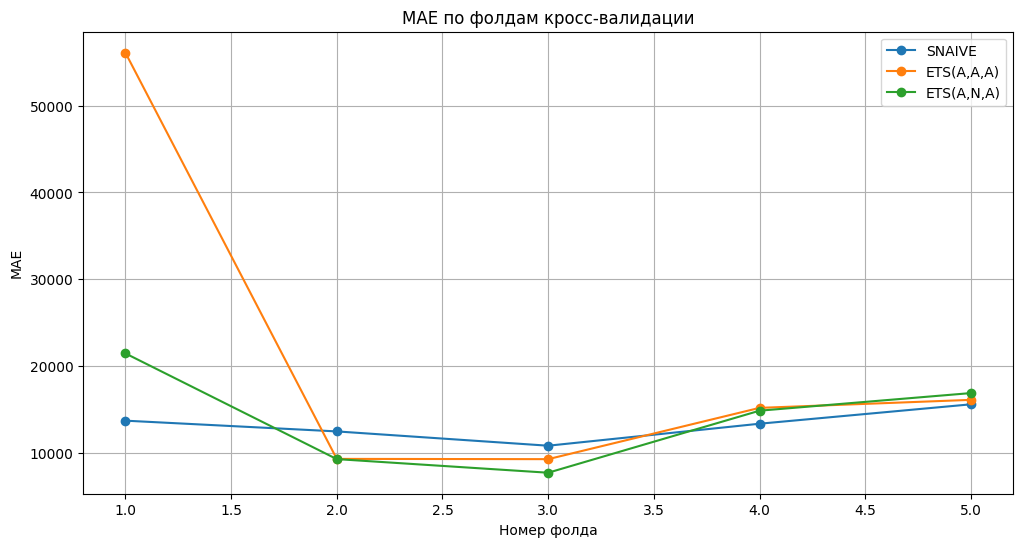

In [31]:
# Визуализируем результаты кросс-валидации растущим окном

plt.figure(figsize=(12, 6))
for model_name, results in cv_results.items():
    plt.plot(results['Fold'], results['MAE'], 'o-', label=model_name)

plt.title('MAE по фолдам кросс-валидации')
plt.xlabel('Номер фолда')
plt.ylabel('MAE')
plt.legend()
plt.grid()
plt.show()